# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|OK|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|OK|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|OK|


### dataset
1. [Naver sentiment movie corpus v1.0](https://github.com/e9t/nsmc/)


### 적용할 알고리즘
1. SentencePiece 
2. LSTM(Long Short Term Memory)


### 텍스트 분류 성능 평가 지표  
1. Accuracy(정확도)

## 문제 정의  

> SentencePiece 사용하여 네이버 영화 리뷰 감성 분석하기

## 분석 결과  

|Tokenizer|model_type|vocab_size|Accuracy|
|:---------:|:----------:|:----------:|:--:|
|SentencePiece|unigram| 5000| 83.23%|
|SentencePiece| bpe|5000| 83.78%| 
|SentencePiece| unigram|8000| 82.65%|
|SentencePiece| bpe|8000| 83.26%|
|형태소분석기| Mecab|10000|83.44 %|  

  
* 네이버 영화리뷰 감성 분석에서는 oov가 크게 문제가 되지 않는 것으로 보임.
형태소 분석기와 SentencePiece tokenizer 결합 시에 정확도가 크게 차이가 나지 않음
* SentencePiece 결합 시에 model type, 단어 개수에 따른 정확도 차이가 나지 않음



## 분석환경

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image
#Image(filename='test.jpg

import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt, Mecab
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기 
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## 1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기 

### 1) 데이터 로드하기

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f61291cbc70>)

In [4]:
data = pd.read_table('ratings.txt')

In [5]:
data.shape
print("리뷰 개수 :", len(data))

(200000, 3)

리뷰 개수 : 200000


In [6]:
data.head(5)
#data.sample(5)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 2) 데이터 정제하기

* id 열 제거
* Null 제거
* 중복 제거
* 숫자, 영어, 한글과 공백을 제외하고 모두 제거

In [7]:
# id 열 제거
data.drop('id',axis=1,inplace=True)
data

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
199995,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,쓰.레.기,0
199997,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [8]:
#### document 열의 중복 제거 
data.duplicated(['document']).sum()
data.drop_duplicates(subset=['document'], inplace=True)
len(data)

5456

194544

In [9]:
### null 제거
data[data['document'].isnull()]
data.dropna(inplace=True)

,document,label
46471,NaN,1


In [10]:
print("리뷰 개수 :", len(data))

리뷰 개수 : 194543


In [11]:
data[data['document'].str.contains("[a-zA-Z]+")]

,document,label
25,"7시간짜리 영상이 존재한다면, 죽기전에 꼭 한번 보고싶다. 아름답고 슬픈 OST, ...",1
83,ost 때문에 봤는데 이건뭐 와~~라는 말밖에 안나오네 벌써 16년전인데 이런퀄리티...,1
91,SF영화 중 21세기 최고라고 할 수 있다..이걸 평점 낮게주는 사람은 정말 볼줄을...,1
96,amy6250 당신이 좋아하는 장르는 뭐요? 이영화에도 저영화에도 이런장르는 싫다니원,1
129,개인적으로 재미있었습니다. 언제 팬텀이랑 크리스틴이랑 그런일이 있었는지 전혀 몰랐네...,1
...,...,...
199894,올레tv 추천 무료영화엔 왜 이딴것 밖에 안올라 올까...,0
199903,cg도 엉망 그냥 시디과 애들이 만드는게 훨씬 더 볼만할듯함스토리텔링도 완전 엉망 ...,0
199910,소재는 좋았는데 tv 전가세가 아까웠다!!,0
199914,과포장 되어 있다.acs,0


In [12]:
# 숫자, 영어, 한글과 공백을 제외하고 모두 제거
data['document'] = data['document'].str.replace("[^a-zA-Z1-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
data['document'] = data['document'].str.strip()
#data['document'].str.replace('^ +', "")
data['document'].replace('',np.nan, inplace=True)
data[:10]

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
5,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,완전 감동입니다 다시봐도 감동,1
7,개들의 전쟁2 나오나요 나오면 1빠로 보고 싶음,1
8,굿,1
9,바보가 아니라 병 쉰 인듯,1


In [13]:
#### document 열의 중복 제거 
data.duplicated(['document']).sum()
data.drop_duplicates(subset=['document'], inplace=True)
len(data)

2735

191808

In [14]:
### null 제거
data[data['document'].isnull()]
data.dropna(inplace=True)

,document,label
1199,NaN,1


In [15]:
print("전처리 후의 리뷰 개수 :", len(data))

전처리 후의 리뷰 개수 : 191807


### 3) SentencePiece 모델 학습

In [16]:
# 문장 답기
corpus = [] 
for sen in data['document']:
   corpus.append(sen)

corpus[:10]
corpus[0], len(corpus[0])
len(corpus)

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ',
 '디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다',
 '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음 최고',
 '와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화',
 '사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화',
 '완전 감동입니다 다시봐도 감동',
 '개들의 전쟁2 나오나요 나오면 1빠로 보고 싶음',
 '굿',
 '바보가 아니라 병 쉰 인듯']

('어릴때보고 지금다시봐도 재밌어요ㅋㅋ', 19)

191807

#### text 파일로 저장

In [ ]:
temp_file = './sp_tokenizer/naver_review.txt'

with open(temp_file, 'w', encoding='utf8') as f:
    for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

#### SentencePiece로 단어 집합(vocab) 생성

* spm.model, spm.vocab 생성  

인자 확인 
* input : 학습시킬 파일
* model_prefix : 만들어질 모델 이름
* vocab_size : 단어 집합의 크기
* model_type : 사용할 모델 (unigram(default), bpe, char, word)
* max_sentence_length: 문장의 최대 길이
* pad_id, pad_piece: pad token id, 값
* unk_id, unk_piece: unknown token id, 값
* bos_id, bos_piece: begin of sentence token id, 값
* eos_id, eos_piece: end of sequence token id, 값
* user_defined_symbols: 사용자 정의 토큰



#### SentencePiece 모델 학습
* model_type = unigram
* vocab_size = 5000

In [23]:
import sentencepiece as spm

temp_file = './sp_tokenizer/naver_review.txt'
vocab_size = 5000
model_type = 'unigram'

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=unigram_5000_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, model_type)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./sp_tokenizer/naver_review.txt --model_prefix=unigram_5000_spm --vocab_size=5000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./sp_tokenizer/naver_review.txt
  input_format: 
  model_prefix: unigram_5000_spm
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id:

#### SentencePiece 모델 학습
* model_type = bpe
* vocab_size = 5000

In [24]:
import sentencepiece as spm

temp_file = './sp_tokenizer/naver_review.txt'
vocab_size = 5000
model_type = 'bpe'

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=bpe_5000_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, model_type)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./sp_tokenizer/naver_review.txt --model_prefix=bpe_5000_spm --vocab_size=5000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./sp_tokenizer/naver_review.txt
  input_format: 
  model_prefix: bpe_5000_spm
  model_type: BPE
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece:

bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=287 min_freq=26
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=285 size=2020 all=331715 active=17151 piece=▁장면은
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=281 size=2040 all=332914 active=18350 piece=▁아마
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=278 size=2060 all=334017 active=19453 piece=▁거지
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=275 size=2080 all=335064 active=20500 piece=▁ᄒᄒᄒ
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=271 size=2100 all=336576 active=22012 piece=▁어렵
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=271 min_freq=25
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=268 size=2120 all=337651 active=17868 piece=▁진부한
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=264 size=2140 all=338810 active=19027 piece=가요
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=263 size=2160 all=340099 active=20316 piece=▁반전이
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=260 size=

#### SentencePiece 모델 학습
* model_type = unigram
* vocab_size = 8000

In [25]:
import sentencepiece as spm

temp_file = './sp_tokenizer/naver_review.txt'
vocab_size = 8000
model_type = 'unigram'

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=unigram_8000_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size,model_type)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./sp_tokenizer/naver_review.txt --model_prefix=unigram_8000_spm --vocab_size=8000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./sp_tokenizer/naver_review.txt
  input_format: 
  model_prefix: unigram_8000_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id:

#### SentencePiece 모델 학습
* model_type = bpe
* vocab_size = 8000

In [26]:
import sentencepiece as spm

temp_file = './sp_tokenizer/naver_review.txt'
vocab_size = 8000
model_type = 'bpe'

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=bpe_8000_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, model_type)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./sp_tokenizer/naver_review.txt --model_prefix=bpe_8000_spm --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./sp_tokenizer/naver_review.txt
  input_format: 
  model_prefix: bpe_8000_spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece:

#### 학습된 SentencePiece 모델 확인
* model_type = unigram
* vocab_size = 5000

In [27]:
import pandas as pd
vocab_list = pd.read_csv('unigram_5000_spm.vocab', sep='\t', header=None, quoting=0)
vocab_list[:10]
len(vocab_list)

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.01807
4,이,-4.12561
5,가,-4.50859
6,의,-4.52975
7,▁영화,-4.53354
8,도,-4.61877
9,는,-4.63946


5000

In [28]:
import sentencepiece as spm
uni_five_sp = spm.SentencePieceProcessor()
uni_five_sp.Load('unigram_5000_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = uni_five_sp.EncodeAsIds('아버지가방에들어가신다')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(uni_five_sp.SampleEncodeAsPieces('아버지가방에들어가신다',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(uni_five_sp.DecodeIds(tokensIDs))

True

[1579, 5, 277, 12, 1502, 5, 97, 13]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다']
아버지가방에들어가신다


#### 학습된 SentencePiece 모델 확인
* model_type = bpe
* vocab_size = 5000

In [29]:
bpe_five_sp = spm.SentencePieceProcessor()
bpe_five_sp.Load('bpe_5000_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = bpe_five_sp.EncodeAsIds('아버지가방에들어가신다')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(bpe_five_sp.SampleEncodeAsPieces('아버지가방에들어가신다',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(bpe_five_sp.DecodeIds(tokensIDs))

True

[6, 3566, 833, 3645, 3401, 1338, 3397, 3493, 3391]
['▁아', '버', '지가', '방', '에', '들어', '가', '신', '다']
아버지가방에들어가신다


#### 학습된 SentencePiece 모델 확인
* model_type = unigram
* vocab_size = 8000

In [30]:
uni_eight_sp = spm.SentencePieceProcessor()
uni_eight_sp.Load('unigram_8000_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = uni_eight_sp.EncodeAsIds('아버지가방에들어가신다')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(uni_eight_sp.SampleEncodeAsPieces('아버지가방에들어가신다',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(uni_eight_sp.DecodeIds(tokensIDs))

True

[1323, 6, 374, 11, 1294, 6, 123, 13]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다']
아버지가방에들어가신다


#### 학습된 SentencePiece 모델 확인
* model_type = bpe
* vocab_size = 8000

In [31]:
bpe_eight_sp = spm.SentencePieceProcessor()
bpe_eight_sp.Load('bpe_8000_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = bpe_eight_sp.EncodeAsIds('아버지가방에들어가신다')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(bpe_eight_sp.SampleEncodeAsPieces('아버지가방에들어가신다',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(bpe_eight_sp.DecodeIds(tokensIDs))

True

[4648, 833, 6645, 6401, 1338, 6397, 6493, 6391]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다']
아버지가방에들어가신다


## 2. Tokenizer 함수 작성

#### sp_tokenize() 함수 정의
> 1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list를 전달
> 2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환. 
> 3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding 작업  
> 4. 최대 문장 길이 지정(max_len)
     * 데이터셋 내 문장 길이 분포
     * 적절한 최대 문장 길이 지정

#### 학습된 모델로 sp_tokenize() 메소드 구현
* model_type = unigram
* vocab_size = 5000

리뷰의 최대 길이 : 134
리뷰의 평균 길이 : 17.565114933240185


(array([8.9110e+03, 2.5806e+04, 2.0682e+04, 2.8539e+04, 2.3713e+04,
        1.3108e+04, 1.5954e+04, 1.1969e+04, 5.9220e+03, 6.4970e+03,
        4.7110e+03, 2.3640e+03, 3.0310e+03, 2.5890e+03, 1.4240e+03,
        2.0410e+03, 1.7490e+03, 1.0400e+03, 1.4600e+03, 1.3970e+03,
        8.5100e+02, 1.2980e+03, 1.2280e+03, 7.9900e+02, 1.1450e+03,
        9.5100e+02, 5.1100e+02, 6.6500e+02, 4.9100e+02, 2.3000e+02,
        2.5600e+02, 1.9300e+02, 8.0000e+01, 5.6000e+01, 5.3000e+01,
        2.1000e+01, 2.2000e+01, 1.9000e+01, 5.0000e+00, 1.0000e+01,
        8.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.  ,   3.66,   6.32,   8.98,  11.64,  14.3 ,  16.96,  19.62,
         22.28,  24.94,  27.6 ,  30.26,  32.92,  35.58,  38.24,  40.9 ,
         43.56,  46.22,  48.88,  51.54,  54.2 ,  56.86,  59.52,  62.18,
         64.84,  67.5 ,  70.16,  72.82,  75.48,  78.14,  80.8 ,  83.46,
         86.12,  88.78,  91.44

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

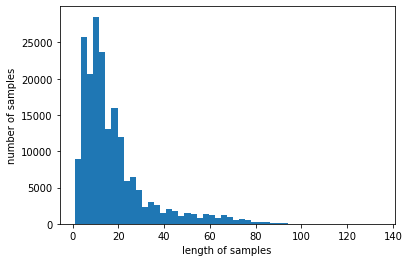

In [33]:
X = []

for sen in corpus:
    X.append(uni_five_sp.EncodeAsIds(sen))
    
print('리뷰의 최대 길이 :',max(len(review) for review in X))
print('리뷰의 평균 길이 :',sum(map(len, X))/len(X))

plt.hist([len(review) for review in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [36]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [37]:
max_len = 50
below_threshold_len(max_len, X)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.38133123400084


In [38]:
def sp_tokenize(s, corpus, vocab="./unigram_5000_spm.vocab",):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(vocab, 'r') as f:    
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen=max_len)

    return tensor, word_index, index_word

In [39]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다', '그러나 여전히 ㅠㅠ 배가 고픕니다']
tensor, word_index, index_word = sp_tokenize(uni_five_sp, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  710 2989   10 1102 1294]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 1742
  2680  323  508    5    3   11 4945  393]]


#### 학습된 모델로 sp_tokenize() 메소드 구현
* model_type = bpe
* vocab_size = 5000

리뷰의 최대 길이 : 123
리뷰의 평균 길이 : 17.26946357536482


(array([8.7840e+03, 1.6281e+04, 3.1405e+04, 1.9874e+04, 2.5531e+04,
        1.4143e+04, 1.7551e+04, 9.2530e+03, 7.4120e+03, 7.9220e+03,
        3.8750e+03, 4.4880e+03, 2.3370e+03, 2.9460e+03, 1.7130e+03,
        2.2710e+03, 1.2970e+03, 1.2200e+03, 1.6700e+03, 1.0210e+03,
        1.4090e+03, 9.0500e+02, 1.3140e+03, 8.6500e+02, 8.9100e+02,
        1.2220e+03, 7.4400e+02, 9.6700e+02, 5.7300e+02, 6.7400e+02,
        2.8300e+02, 3.6300e+02, 1.6000e+02, 1.2500e+02, 1.1900e+02,
        5.0000e+01, 4.9000e+01, 1.8000e+01, 2.2000e+01, 1.7000e+01,
        1.8000e+01, 6.0000e+00, 5.0000e+00, 6.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  1.  ,   3.44,   5.88,   8.32,  10.76,  13.2 ,  15.64,  18.08,
         20.52,  22.96,  25.4 ,  27.84,  30.28,  32.72,  35.16,  37.6 ,
         40.04,  42.48,  44.92,  47.36,  49.8 ,  52.24,  54.68,  57.12,
         59.56,  62.  ,  64.44,  66.88,  69.32,  71.76,  74.2 ,  76.64,
         79.08,  81.52,  83.96

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

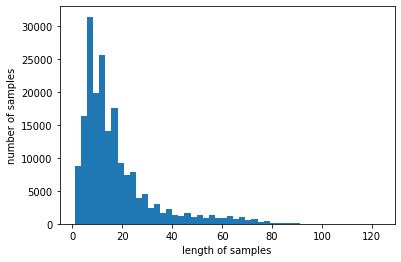

In [40]:
X = []

for sen in corpus:
    X.append(bpe_five_sp.EncodeAsIds(sen))
    
print('리뷰의 최대 길이 :',max(len(review) for review in X))
print('리뷰의 평균 길이 :',sum(map(len, X))/len(X))

plt.hist([len(review) for review in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [41]:
max_len = 50
below_threshold_len(max_len, X)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.60447220382989


In [42]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다', '그러나 여전히 ㅠㅠ 배가 고픕니다']
tensor, word_index, index_word = sp_tokenize(bpe_five_sp, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  703 2543 3414  552  813]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1589 2371  322   76 3397  140 4717   12]]


#### 학습된 모델로 sp_tokenize() 메소드 구현
* model_type = unigram
* vocab_size = 8000

리뷰의 최대 길이 : 117
리뷰의 평균 길이 : 15.837425120042543


(array([1.1498e+04, 1.9610e+04, 2.2676e+04, 3.1588e+04, 1.7792e+04,
        1.5011e+04, 1.8181e+04, 9.2420e+03, 7.2070e+03, 7.6110e+03,
        3.7010e+03, 3.0360e+03, 3.5730e+03, 1.9660e+03, 1.7600e+03,
        2.3290e+03, 1.3020e+03, 1.2220e+03, 1.7270e+03, 1.0410e+03,
        1.0270e+03, 1.3980e+03, 9.3000e+02, 9.2700e+02, 8.8600e+02,
        1.1570e+03, 6.9100e+02, 5.8000e+02, 7.0200e+02, 3.4000e+02,
        2.5700e+02, 3.0500e+02, 1.3800e+02, 1.2600e+02, 1.0800e+02,
        3.5000e+01, 3.6000e+01, 2.8000e+01, 1.1000e+01, 1.7000e+01,
        1.3000e+01, 5.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  1.  ,   3.32,   5.64,   7.96,  10.28,  12.6 ,  14.92,  17.24,
         19.56,  21.88,  24.2 ,  26.52,  28.84,  31.16,  33.48,  35.8 ,
         38.12,  40.44,  42.76,  45.08,  47.4 ,  49.72,  52.04,  54.36,
         56.68,  59.  ,  61.32,  63.64,  65.96,  68.28,  70.6 ,  72.92,
         75.24,  77.56,  79.88

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

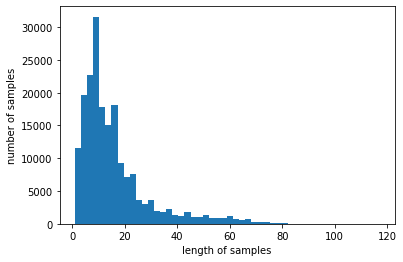

In [43]:
X = []

for sen in corpus:
    X.append(uni_eight_sp.EncodeAsIds(sen))
    
print('리뷰의 최대 길이 :',max(len(review) for review in X))
print('리뷰의 평균 길이 :',sum(map(len, X))/len(X))

plt.hist([len(review) for review in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



In [44]:
max_len = 50
below_threshold_len(max_len, X)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 95.71913433816283


In [45]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다', '그러나 여전히 ㅠㅠ 배가 고픕니다']
tensor, word_index, index_word = sp_tokenize(uni_eight_sp, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  541 2647   10 1148 2095]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 1475
  2349  240  534    6    3   12 7945  892]]


#### 학습된 모델로 sp_tokenize() 메소드 구현
* model_type = bpe
* vocab_size = 8000

리뷰의 최대 길이 : 114
리뷰의 평균 길이 : 15.625248296464676


(array([1.1255e+04, 1.9855e+04, 2.3350e+04, 3.1978e+04, 1.7887e+04,
        1.5268e+04, 1.2755e+04, 1.4464e+04, 7.0740e+03, 5.2330e+03,
        4.0590e+03, 4.4870e+03, 2.4670e+03, 2.0700e+03, 1.8360e+03,
        2.3710e+03, 1.4480e+03, 1.2570e+03, 1.1860e+03, 1.6410e+03,
        9.7500e+02, 1.0240e+03, 9.2600e+02, 1.4660e+03, 9.2800e+02,
        8.0000e+02, 1.0790e+03, 5.9200e+02, 5.0800e+02, 4.0600e+02,
        4.2300e+02, 2.1800e+02, 1.4400e+02, 9.5000e+01, 1.0900e+02,
        5.1000e+01, 2.9000e+01, 1.9000e+01, 2.2000e+01, 1.2000e+01,
        1.2000e+01, 6.0000e+00, 1.0000e+01, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  1.  ,   3.26,   5.52,   7.78,  10.04,  12.3 ,  14.56,  16.82,
         19.08,  21.34,  23.6 ,  25.86,  28.12,  30.38,  32.64,  34.9 ,
         37.16,  39.42,  41.68,  43.94,  46.2 ,  48.46,  50.72,  52.98,
         55.24,  57.5 ,  59.76,  62.02,  64.28,  66.54,  68.8 ,  71.06,
         73.32,  75.58,  77.84

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

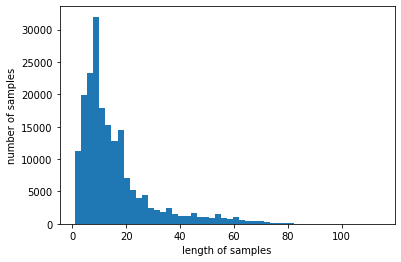

In [46]:
X = []

for sen in corpus:
    X.append(bpe_eight_sp.EncodeAsIds(sen))
    
print('리뷰의 최대 길이 :',max(len(review) for review in X))
print('리뷰의 평균 길이 :',sum(map(len, X))/len(X))

plt.hist([len(review) for review in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [47]:
max_len = 50
below_threshold_len(max_len, X)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 95.8984812858759


In [48]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다', '그러나 여전히 ㅠㅠ 배가 고픕니다']
tensor, word_index, index_word = sp_tokenize(bpe_eight_sp, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  703 2543 6414  552  813]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1589 2371  322   76 6397  140 7717   12]]


## 3. SentencePiece 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기

### 1) 데이터 로드하기

In [49]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_train.txt', <http.client.HTTPMessage at 0x7f60aa7970a0>)

('ratings_test.txt', <http.client.HTTPMessage at 0x7f60aa797490>)

In [50]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [51]:
train_data.shape
test_data.shape
train_data.head(5)
test_data.head(5)

(150000, 3)

(50000, 3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2) 데이터 정제하기

* id 열 제거
* Null 제거
* 중복 제거
* 숫자, 영어, 한글과 공백을 제외하고 모두 제거

In [52]:
# id 열 제거
train_data.drop('id',axis=1,inplace=True)
test_data.drop('id',axis=1,inplace=True)
train_data
test_data

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
149995,인간이 문제지.. 소는 뭔죄인가..,0
149996,평점이 너무 낮아서...,1
149997,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...
49995,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [53]:
#### document 열의 중복 제거 
train_data.duplicated(['document']).sum()
train_data.drop_duplicates(subset=['document'], inplace=True)
len(train_data)

test_data.duplicated(['document']).sum()
test_data.drop_duplicates(subset=['document'], inplace=True)
len(test_data)

3817

146183

842

49158

In [54]:
### null 제거
train_data.isnull().sum()
train_data[train_data['document'].isnull()]
train_data.dropna(inplace=True)

test_data.isnull().sum()
test_data[test_data['document'].isnull()]
test_data.dropna(inplace=True)

document    1
label       0
dtype: int64

,document,label
25857,NaN,1


document    1
label       0
dtype: int64

,document,label
5746,NaN,1


In [55]:
print("train data 개수",len(train_data))
print("test data 개수", len(test_data))

train data 개수 146182
test data 개수 49157


In [56]:
train_data[train_data['document'].str.contains("[a-zA-Z]+")]
test_data[test_data['document'].str.contains("[a-zA-Z]+")]

,document,label
26,kl2g 고추를 털어버려야 할텐데,1
53,"난또 저 꼬마애가 무슨 원한이 깊길래.,. 했더니 OO 그냥 혼자 나대다 OO걸 어...",0
69,노래실력으로뽑는게 맞냐? 박시환이 mama나가면 진짜 망신이다,0
116,몬스터 주식회사 3D 재밌게 봤다,1
163,종방되어 아쉬워요. 오늘막방도 잘봤어요.방송대본이 꽤 완성도있다는 느낌받았고요. 요...,1
...,...,...
149923,"만들기 싫은데 어거지로 만든 영화 ㅋㅋ 돈날리면서 왜 이렇게 굳이,., 그냥 개인 ...",0
149962,tv 전기세와 시간이 완전 아깝다!,0
149983,그냥생각없이 평점좀 쓰지마 OOO들아 두 배우의연기가 너무맘에 들었다,1
149991,http://blog.naver.com/oroblast/220215679580 나쁜...,1


,document,label
1,GDNTOPCLASSINTHECLUB,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
8,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1
14,"""스토리, 연출, 연기, 비주얼 등 영화의 기본 조차 안된 영화에 무슨 평을 해. ...",0
...,...,...
49976,스토리가..OOO..,0
49978,amazing,1
49980,영화판의 역사를 알게 되어서 너무 신선했습니다.감독님gv너무 재밌습니다.영화판 화이...,1
49992,내일 토요일밤 MBC에서 영화 해준다.... 봐야지... 기대,1


In [57]:
# 숫자, 영어, 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^a-zA-Z1-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
train_data['document'] = train_data['document'].str.strip()
#train_data['document'].str.replace('^ +', "")
train_data['document'].replace('',np.nan, inplace=True)
train_data[:10]


# 숫자, 영어, 한글과 공백을 제외하고 모두 제거
test_data['document'] = test_data['document'].str.replace("[^a-zA-Z1-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
test_data['document'] = test_data['document'].str.strip()
#test_data['document'].str.replace('^ +', "")
test_data['document'].replace('',np.nan, inplace=True)
test_data[:10]

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화ㅋㅋㅋ별반개도 아까움,0
6,원작의 긴장감을 제대로 살려내지못했다,0
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,액션이 없는데도 재미 있는 몇안되는 영화,1
9,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은 나쁘진 않지만 1점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠,0
5,음악이 주가 된 최고의 음악영화,1
6,진정한 쓰레기,0
7,마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가고개를 젖게한다,0
8,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But 모든 사람이 그렇지는 않네,1


In [58]:
#### document 열의 중복 제거 
train_data.duplicated(['document']).sum()
train_data.drop_duplicates(subset=['document'], inplace=True)
len(train_data)

test_data.duplicated(['document']).sum()
test_data.drop_duplicates(subset=['document'], inplace=True)
len(test_data)

1939

144243

517

48640

In [59]:
### null 제거
train_data[train_data['document'].isnull()]
train_data.dropna(inplace=True)

test_data[test_data['document'].isnull()]
test_data.dropna(inplace=True)

,document,label
1840,NaN,1


,document,label
116,NaN,1


In [60]:
print("전처리 후의 train_data 개수 :", len(train_data))
print("전처리 후의 test_data 개수 :", len(test_data))

전처리 후의 train_data 개수 : 144242
전처리 후의 test_data 개수 : 48639


0    72409
1    71833
Name: label, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

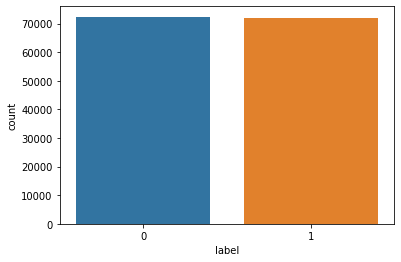

In [61]:
### 레이블(label) 값의 분포
import seaborn as sns
train_data['label'].value_counts()
sns.countplot('label',data=train_data)

1    24431
0    24208
Name: label, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

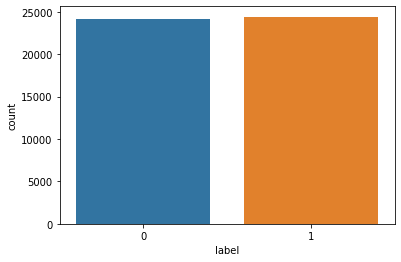

In [62]:
test_data['label'].value_counts()
sns.countplot('label',data=test_data)

####  SentencePiece 토크나이저를 적용할 최종 데이터

In [126]:
X_train = list(train_data['document'].values)
X_test = list(test_data['document'].values)

y_train = train_data['label'].values 
y_test = test_data['label'].values

#X_train
#X_test
#y_train
#y_test

####  SentencePiece 토크나이저를 적용
* model_type = unigram
* vocab_size = 5000

In [67]:
#sp_tokenize(s, corpus) 사용예제

vocab = "./unigram_5000_spm.vocab"
X_train, word_index, index_word = sp_tokenize(uni_five_sp, X_train,vocab)
X_test, word_index, index_word = sp_tokenize(uni_five_sp, X_test,vocab)

In [68]:
X_train[0]
X_test[0]
X_train.shape
X_test.shape
#word_index
#index_word

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         51, 1040,   33, 1231,   46, 1584], dtype=int32)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2958,  373], dtype=int32)

(144242, 50)

(48639, 50)

####  SentencePiece 토크나이저를 적용
* model_type = bpe
* vocab_size = 5000

In [98]:
#sp_tokenize(s, corpus) 사용예제

vocab = "./bpe_5000_spm.vocab"
X_train, word_index, index_word = sp_tokenize(bpe_five_sp, X_train, vocab)
X_test, word_index, index_word = sp_tokenize(bpe_five_sp, X_test, vocab)

In [99]:
X_train[0]
X_test[0]
X_train.shape
X_test.shape
#word_index
#index_word

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          6, 1027,   50, 2381,   36, 1909], dtype=int32)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 1258,  443], dtype=int32)

(144242, 50)

(48639, 50)

####  SentencePiece 토크나이저를 적용
* model_type = unigram
* vocab_size = 8000

In [127]:
#sp_tokenize(s, corpus) 사용예제

vocab = "./unigram_8000_spm.vocab"
X_train, word_index, index_word = sp_tokenize(uni_eight_sp, X_train, vocab)
X_test, word_index, index_word = sp_tokenize(uni_eight_sp, X_test, vocab)

In [128]:
X_train[0]
X_test[0]
X_train.shape
X_test.shape
#word_index
#index_word

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         56,  829,   26, 2161,   53, 1324], dtype=int32)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2634,  297], dtype=int32)

(144242, 50)

(48639, 50)

####  SentencePiece 토크나이저를 적용
* model_type = bpe
* vocab_size = 8000

In [114]:
#sp_tokenize(s, corpus) 사용예제

vocab = "./bpe_8000_spm.vocab"
X_train, word_index, index_word = sp_tokenize(bpe_eight_sp, X_train, vocab)
X_test, word_index, index_word = sp_tokenize(bpe_eight_sp, X_test, vocab)

In [115]:
X_train[0]
X_test[0]
X_train.shape
X_test.shape
#word_index
#index_word

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          6, 1027,   50, 2381,   36, 1909], dtype=int32)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 1258,  443], dtype=int32)

(144242, 50)

(48639, 50)

### 3) validation set 구성

#### 검증셋 : 훈련셋 을 2:8 비율로 분리

In [129]:
print(X_train.shape[0])
print(int(X_train.shape[0] * 0.2))
print(X_train.shape[0] - int(X_train.shape[0] * 0.2))

144242
28848
115394


In [130]:
# validation set 28848건 분리
x_val = X_train[:28848]   
y_val = y_train[:28848]

# validation set을 제외한 나머지 115394건
partial_x_train = X_train[28848:]  
partial_y_train = y_train[28848:]

print(x_val.shape)
print(partial_x_train.shape)

(28848, 50)
(115394, 50)


### 4) LSTM으로 네이버 영화 리뷰 감성 분류하기

#### SentencePiece
* model_type = unigram
* vocab_size = 5000

In [71]:
vocab_size = 5000    # 어휘 사전의 크기입니다(5,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [72]:
import tensorflow as tf

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
#model_lstm.add(tf.keras.layers.LSTM(100,activation='tanh'))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
226/226 [==============================] - 27s 12ms/step - loss: 0.4443 - accuracy: 0.7912 - val_loss: 0.3600 - val_accuracy: 0.8411
Epoch 2/10
226/226 [==============================] - 2s 10ms/step - loss: 0.3524 - accuracy: 0.8463 - val_loss: 0.3496 - val_accuracy: 0.8447
Epoch 3/10
226/226 [==============================] - 2s 10ms/step - loss: 0.3343 - accuracy: 0.8542 - val_loss: 0.3428 - val_accuracy: 0.8483
Epoch 4/10
226/226 [==============================] - 2s 10ms/step - loss: 0.3134 - accuracy: 0.8642 - val_loss: 0.3430 - val_accuracy: 0.8504
Epoch 5/10
226/226 [==============================] - 2s 10ms/step - loss: 0.2946 - accuracy: 0.8714 - val_loss: 0.3422 - val_accuracy: 0.8504
Epoch 6/10
226/226 [==============================] - 2s 10ms/step - loss: 0.2762 - accuracy: 0.8802 - val_loss: 0.3528 - val_accuracy: 0.8513
Epoch 7/10
226/226 [==============================] - 2s 10ms/step - loss: 0.2591 - accuracy: 0.8879 - val_loss: 0.3646 - val_accuracy: 0.848

In [74]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1520/1520 - 3s - loss: 0.4138 - accuracy: 0.8323
[0.4137531816959381, 0.8323156237602234]


In [75]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

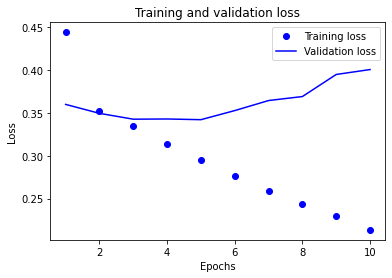

In [76]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

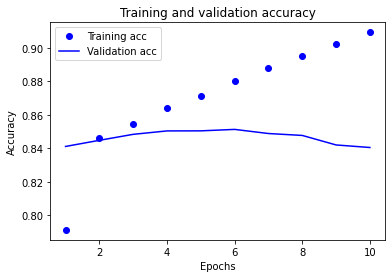

In [77]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### SentencePiece
* model_type = bpe
* vocab_size = 5000

In [88]:
vocab_size = 5000    # 어휘 사전의 크기입니다(5,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [89]:
import tensorflow as tf

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
#model_lstm.add(tf.keras.layers.LSTM(100,activation='tanh'))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
226/226 [==============================] - 4s 14ms/step - loss: 0.4435 - accuracy: 0.7938 - val_loss: 0.3586 - val_accuracy: 0.8412
Epoch 2/10
226/226 [==============================] - 2s 11ms/step - loss: 0.3490 - accuracy: 0.8473 - val_loss: 0.3470 - val_accuracy: 0.8461
Epoch 3/10
226/226 [==============================] - 2s 11ms/step - loss: 0.3266 - accuracy: 0.8574 - val_loss: 0.3394 - val_accuracy: 0.8495
Epoch 4/10
226/226 [==============================] - 2s 11ms/step - loss: 0.3054 - accuracy: 0.8670 - val_loss: 0.3360 - val_accuracy: 0.8504
Epoch 5/10
226/226 [==============================] - 2s 11ms/step - loss: 0.2854 - accuracy: 0.8757 - val_loss: 0.3416 - val_accuracy: 0.8517
Epoch 6/10
226/226 [==============================] - 2s 11ms/step - loss: 0.2662 - accuracy: 0.8847 - val_loss: 0.3519 - val_accuracy: 0.8513
Epoch 7/10
226/226 [==============================] - 2s 11ms/step - loss: 0.2489 - accuracy: 0.8927 - val_loss: 0.3680 - val_accuracy: 0.8472

In [91]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1520/1520 - 3s - loss: 0.4421 - accuracy: 0.8378
[0.44208383560180664, 0.8377639055252075]


In [92]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

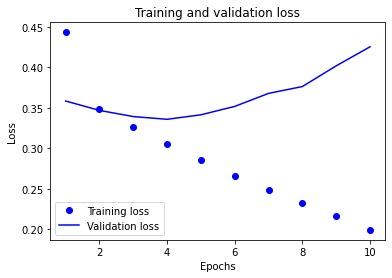

In [93]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

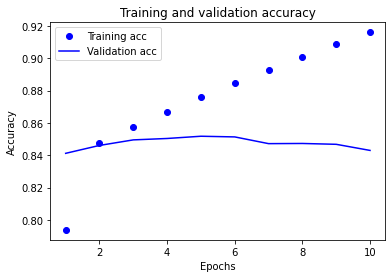

In [94]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### SentencePiece
* model_type = unigram
* vocab_size = 8000

In [131]:
vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [132]:
import tensorflow as tf

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
#model_lstm.add(tf.keras.layers.LSTM(100,activation='tanh'))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 880,501
Trainable params: 880,501
Non-trainable params: 0
_________________________________________________________________


In [133]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
226/226 [==============================] - 4s 13ms/step - loss: 0.4367 - accuracy: 0.7967 - val_loss: 0.3504 - val_accuracy: 0.8472
Epoch 2/10
226/226 [==============================] - 3s 11ms/step - loss: 0.3307 - accuracy: 0.8573 - val_loss: 0.3364 - val_accuracy: 0.8517
Epoch 3/10
226/226 [==============================] - 3s 11ms/step - loss: 0.3030 - accuracy: 0.8692 - val_loss: 0.3336 - val_accuracy: 0.8544
Epoch 4/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2754 - accuracy: 0.8820 - val_loss: 0.3383 - val_accuracy: 0.8534
Epoch 5/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2508 - accuracy: 0.8926 - val_loss: 0.3531 - val_accuracy: 0.8503
Epoch 6/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2268 - accuracy: 0.9033 - val_loss: 0.3813 - val_accuracy: 0.8490
Epoch 7/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2053 - accuracy: 0.9140 - val_loss: 0.4110 - val_accuracy: 0.8470

In [134]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1520/1520 - 3s - loss: 0.5405 - accuracy: 0.8265
[0.5404857993125916, 0.8265178203582764]


In [135]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

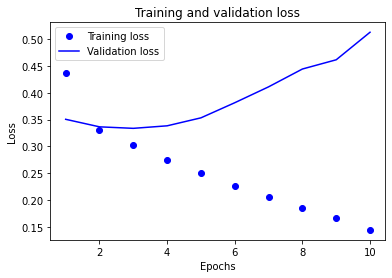

In [136]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

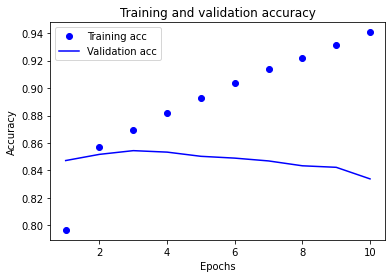

In [137]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### SentencePiece
* model_type = bpe
* vocab_size = 8000

In [118]:
vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [119]:
import tensorflow as tf

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
#model_lstm.add(tf.keras.layers.LSTM(100,activation='tanh'))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 880,501
Trainable params: 880,501
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
226/226 [==============================] - 4s 13ms/step - loss: 0.4392 - accuracy: 0.7947 - val_loss: 0.3505 - val_accuracy: 0.8476
Epoch 2/10
226/226 [==============================] - 3s 11ms/step - loss: 0.3325 - accuracy: 0.8563 - val_loss: 0.3380 - val_accuracy: 0.8516
Epoch 3/10
226/226 [==============================] - 3s 11ms/step - loss: 0.3068 - accuracy: 0.8669 - val_loss: 0.3334 - val_accuracy: 0.8530
Epoch 4/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2820 - accuracy: 0.8782 - val_loss: 0.3404 - val_accuracy: 0.8536
Epoch 5/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2579 - accuracy: 0.8891 - val_loss: 0.3469 - val_accuracy: 0.8517
Epoch 6/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2354 - accuracy: 0.8986 - val_loss: 0.3618 - val_accuracy: 0.8494
Epoch 7/10
226/226 [==============================] - 3s 11ms/step - loss: 0.2131 - accuracy: 0.9086 - val_loss: 0.3984 - val_accuracy: 0.8474

In [121]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1520/1520 - 3s - loss: 0.5397 - accuracy: 0.8326
[0.5396754145622253, 0.8325623273849487]


In [122]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

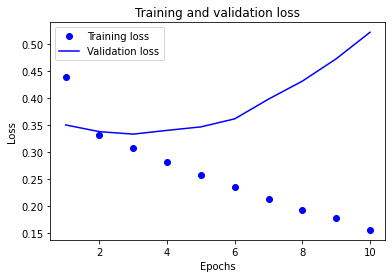

In [123]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

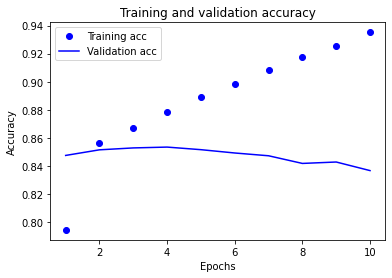

In [124]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

### 1) 데이터로더 구성

In [139]:
from konlpy.tag import Mecab
#from konlpy.tag import Okt
import numpy as np
from collections import Counter

tokenizer = Mecab()
#tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [148]:
index_to_word = {index:word for word, index in word_to_index.items()}
len(index_to_word)

10000

In [141]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


### 2) 모델 구성을 위한 데이터 분석 및 가공

In [143]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  14.145032429321706
문장길이 최대 :  105
문장길이 표준편차 :  11.622114130337575
pad_sequences maxlen :  37
전체 문장의 0.9346436403793013%가 maxlen 설정값 이내에 포함됩니다. 


In [144]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)
print(len(X_train[0]))
print(X_train[0])

(144242, 37)
(48639, 37)
37
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  29  68 915  35 217  15  28
 713]


### 3) 모델 구성 및 validation set 구성

In [149]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [150]:
import tensorflow as tf

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
#model_lstm.add(tf.keras.layers.LSTM(100,activation='tanh'))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


#### validation set 구성

In [151]:
print(X_train.shape[0])
print(int(X_train.shape[0] * 0.2))
print(X_train.shape[0] - int(X_train.shape[0] * 0.2))

144242
28848
115394


In [154]:
# validation set 29235건 분리
x_val = X_train[:28848]   
y_val = y_train[:28848]

# validation set을 제외한 나머지 1116947건
partial_x_train = X_train[28848:]  
partial_y_train = y_train[28848:]

print(x_val.shape)
print(partial_x_train.shape)

(28848, 37)
(115394, 37)


### 4) LTSM 훈련 및 평가

In [155]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
226/226 [==============================] - 4s 11ms/step - loss: 0.4314 - accuracy: 0.8000 - val_loss: 0.3544 - val_accuracy: 0.8470
Epoch 2/10
226/226 [==============================] - 2s 9ms/step - loss: 0.3310 - accuracy: 0.8576 - val_loss: 0.3457 - val_accuracy: 0.8467
Epoch 3/10
226/226 [==============================] - 2s 9ms/step - loss: 0.3013 - accuracy: 0.8709 - val_loss: 0.3408 - val_accuracy: 0.8501
Epoch 4/10
226/226 [==============================] - 2s 9ms/step - loss: 0.2733 - accuracy: 0.8840 - val_loss: 0.3519 - val_accuracy: 0.8491
Epoch 5/10
226/226 [==============================] - 2s 9ms/step - loss: 0.2480 - accuracy: 0.8965 - val_loss: 0.3587 - val_accuracy: 0.8502
Epoch 6/10
226/226 [==============================] - 2s 9ms/step - loss: 0.2242 - accuracy: 0.9075 - val_loss: 0.3863 - val_accuracy: 0.8479
Epoch 7/10
226/226 [==============================] - 2s 9ms/step - loss: 0.2021 - accuracy: 0.9171 - val_loss: 0.4041 - val_accuracy: 0.8442
Epoch

In [156]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1520/1520 - 3s - loss: 0.5320 - accuracy: 0.8344
[0.532029926776886, 0.8344332575798035]


In [157]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

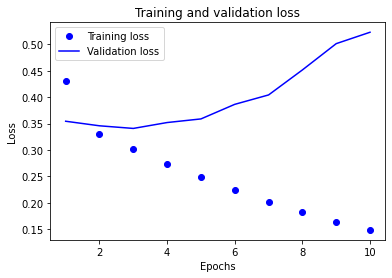

In [158]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

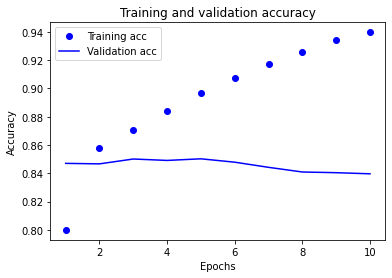

In [159]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고

* 네이버 영화리뷰 감성 분석에서는 oov가 크게 문제가 되지 않는 것으로 보임.
형태소 분석기와 SentencePiece tokenizer 결합 시에 정확도가 크게 차이가 나지 않음
* SentencePiece 결합 시에 model type, 단어 개수에 따른 정확도 차이가 나지 않음



## 참고 문헌
* [딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/86657)